# Checking and manually adjustmenting analysis regions for SDSSRM-XCS

This notebook will allow us to go through combined images (i.e. all available data for each cluster) and inspect the source regions that are being used to remove contaminant emission. Then we can choose whether or not to adjust the regions, and if so we can save those changes to new custom region files that will be inserted into the XGA analysis.

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError
from astropy.cosmology import LambdaCDM, WMAP9
%matplotlib widget
from typing import Union, List
from shutil import rmtree
import os

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import xcs3p_colour, xcs_cosmo

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 20
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.products import Image
from xga.imagetools.misc import physical_rad_to_pix

import warnings
warnings.filterwarnings('ignore')

## Declaring XGA ClusterSample for SDSSRM-XCS

In [2]:
xcs3p = pd.read_csv("../../sample_files/xcs3p_sdssrm_vol_lim_temperr_25%_clusters.csv")
xcs3p = xcs3p[30:33]

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xcs3p['xapa_ra'].values
dec = xcs3p['xapa_dec'].values
z = xcs3p['z'].values
# Not using the IAU names in XCS_NAME column, its easier for me to use the name based on redMaPPer ID
n = xcs3p['name'].values
# In arcminutes, ClusterSample declaration will convert to kpc using the provided cosmology
r500 = Quantity(xcs3p['r500'].values, 'arcmin')
# Not likely to use richness in this notebook, but I'm putting it in the sample object anyway
r = xcs3p['richness'].values
r_err = xcs3p['richness_err'].values

# Declaring the actual ClusterSample instance for the XCS sample
xcs_srcs = ClusterSample(ra, dec, z, n, r500=r500, richness=r, richness_err=r_err, cosmology=xcs_cosmo, 
                         load_fits=True, use_peak=True, clean_obs=True, clean_obs_reg='r500', 
                         clean_obs_threshold=0.7)

Setting up Galaxy Clusters: 100%|███████████████████████████████████████████████| 3/3 [00:16<00:00,  5.60s/it]


## Setting up region storage directories

This just sets up the storage structure for the output region files.

In [4]:
if not os.path.exists('../../outputs/custom_regions/sdssrm-xcs'):
    os.makedirs('../../outputs/custom_regions/sdssrm-xcs')

for src in xcs_srcs:
    sp_pth = '../../outputs/custom_regions/sdssrm-xcs/{n}'.format(n=src.name)
    if not os.path.exists(sp_pth):
        os.makedirs(sp_pth)

## Region checking and adjustment

This part of the notebook allows us to directly interact with images and their regions - therefore modifications can be made to the source regions, or new regions added, to properly remove contaminating emission that might bias our analyses.

In [5]:
# plt.close('all')

SDSSXCS-6955


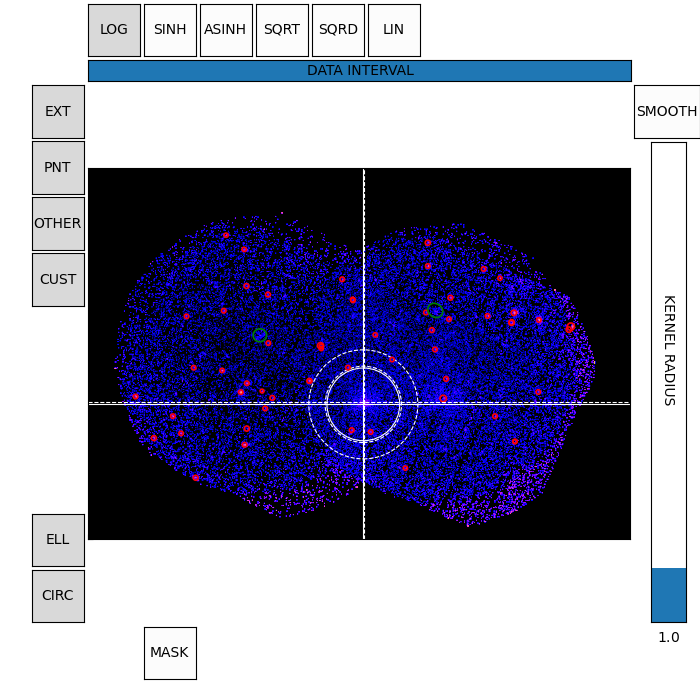

In [7]:
src = xcs_srcs[0]
print(src.name)

crt = src.get_combined_ratemaps(lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))
crt.regions = src.get_interloper_regions(flattened=False)
save_path = "../../outputs/custom_regions/sdssrm-xcs/{n}/mod_{n}.reg".format(n=src.name)

analysis_radius = src.r500*1.2
pix_analysis = physical_rad_to_pix(crt, analysis_radius, src.peak, src.redshift, src.cosmo)
pix_inn_back = physical_rad_to_pix(crt, analysis_radius*1.05, src.peak, src.redshift, src.cosmo)
pix_out_back = physical_rad_to_pix(crt, analysis_radius*1.5, src.peak, src.redshift, src.cosmo)

an_rad = Quantity([0, pix_analysis.value], 'pix')
bck_rad = Quantity([pix_inn_back, pix_out_back])

ch = Quantity([src.peak, src.ra_dec])
# ch = src.peak

# crt.edit_regions(reg_save_path=save_path, cross_hair=ch, radial_bins_pix=an_rad, back_bin_pix=bck_rad)
crt.edit_regions(cross_hair=ch, radial_bins_pix=an_rad, back_bin_pix=bck_rad)

## Notes

* Should revisit SDSSXCS-5 when flare checking is done, as it does look quite flared.
* Same deal with SDSSXCS-21847, it looks like there are lots of observations so losing the flared won't be too bad.
* SDSSXCS-667 as well.
* SDSSXCS-2288 has a readout streak and I'm not sure whether to mask or not
* SDSSXCS-137 looks a bit flarey, edit again after flare checks
* SDSSXCS-30950 might have a dodgy peak
* SDSSXCS-480 has readout streak but am going to put a region on it for the background at least
* SDSSXCS-14 come back once flaring addressed
* SDSSXCS-765 gives a KeyError for '0551020901' - come back once I've figured out the bug
* SDSSXCS-11154 seems like a merging system but one of the components isn't masked out